## Image Denoising using MRFs

Two methods are implemented in this notebook:
* Denoising Binary Images using MinCut (MRF)
* Denoising Colored images using ICM (MRF)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import igraph as ig

# Denoising Binary Images using MinCut

The chosen potentials are useful as the unary potentials represent the probability that the pixel was flipped and the inter-pixel weights represent the change in contrast with the pixels neighbors.

In [45]:
class DeNoiser(object):
    
    def __init__(self, img, beta=0.3, p=0.2, n_iters=3):
        
        print("Initializing...")
        
        self.h = img.shape[0]
        self.w = img.shape[1]
        
        img = img.astype('float32')
        self.original_img = img.copy()
        self.img = img.reshape(-1)
        
        # Initializing parameters
        self.p=p
        self.beta=beta
        self.calculate_V()
        
        # Initializing Graph
        self.s = self.h*self.w
        self.t = self.h*self.w + 1
        
        self.n_iters = n_iters
   
    def calculate_V(self):
        
        # Gets differences between pixels in the required directions
        self.l = np.abs(self.original_img[:, 1:] - self.original_img[:, :-1])
        self.u = np.abs(self.original_img[1:, :] - self.original_img[:-1, :])
        
        # Calculates the V term to add to the graph's edges capacity
        cap_l = self.beta*self.l
        cap_u = self.beta*self.u
        
        # Initializing variables
        self.edges_V = []
        self.capacity_V = []
        l_edges = []
        u_edges = []
        
        # Adds the edges in the required directions
        for i in range(self.h):
            for j in range(self.w):
                curr = i*self.w+j
                if i:
                    u_edges += [((i-1)*self.w+j, curr)]
                if j:
                    l_edges += [(i*self.w+j-1, curr)]
        
        # Updates edges and capacities
        self.edges_V = l_edges + u_edges
        self.capacity_V += cap_l.ravel().tolist() + cap_u.ravel().tolist() 
        
    def create_graph(self):
        
        self.graph = ig.Graph(self.h * self.w + 2)
        
        edges = self.edges_V.copy()
        self.capacity = self.capacity_V.copy()
        
        print("Adding Edges")
        for i in range(self.h*self.w):
            edges += [(self.s, i), (self.t, i)]
            if self.img[i] == 0:
                self.capacity += [-np.log(self.p), -np.log(1-self.p)]
            else:
                self.capacity += [-np.log(1-self.p), -np.log(self.p)]
            
        self.graph.add_edges(edges)
        
    def find_mincut(self):
        
        mincut = self.graph.st_mincut(self.s, self.t, self.capacity)
        self.img3 = self.img.copy()
        
        self.img3[mincut.partition[0][:-1]] = 0
        self.img3[mincut.partition[1][:-1]] = 255
        
        self.img3 = self.img3.reshape(self.h, self.w)
        
        self.original_img = self.img3.copy()
        self.img = self.img3.reshape(-1)
        
    def run(self):
        
        for i in range(self.n_iters):
            print("Creating Graph")
            self.create_graph()

            print("Finding MinCut")
            self.find_mincut()
            
        return self.img3.astype('uint8')
        
        

In [360]:
def add_noise(img, p=0.2):
    
    op = img.copy()
    h,w = img.shape[:2]
    
    for i in range(h):
        for j in range(w):
            
            val = np.random.random()
            if val < p:
                op[i][j] = 1-op[i][j]
    
    return op

def run(img1, p=0.05, beta=2, sf=2, thres=127, g="v", show=True):
    
    h,w = img1.shape[:2]
    h/=sf
    w/=sf
    h,w = int(h), int(w)
    img1 = cv.resize(img1, (w,h))
    
    img1[img1 < thres] = 0
    img1[img1 >= thres] = 1

    noisy = add_noise(img1, p)

    dn = DeNoiser(noisy, beta, p, 1)
    denoised = dn.run()
    
    if not show:
        return noisy, denoised
    
    if show:
        fig = plt.figure(figsize=(12,10))
        if g == "v":
            plt.subplot(221)
            plt.imshow(img1, cmap="gray")
            plt.title("Ground Truth")
            plt.subplot(222)
            plt.imshow(noisy, cmap="gray")
            plt.title("Noisy Input Image")
            plt.subplot(223)
            plt.imshow(denoised, cmap="gray")
            plt.title("De-Noised Output Image")
        else:
            plt.subplot(131)
            plt.imshow(img1, cmap="gray")
            plt.title("Ground Truth")
            plt.subplot(133)
            plt.imshow(noisy, cmap="gray")
            plt.title("Noisy Input Image")
            plt.subplot(132)
            plt.imshow(denoised, cmap="gray")
            plt.title("De-Noised Output Image")


## Example 1

Initializing...
Creating Graph
Adding Edges
Finding MinCut


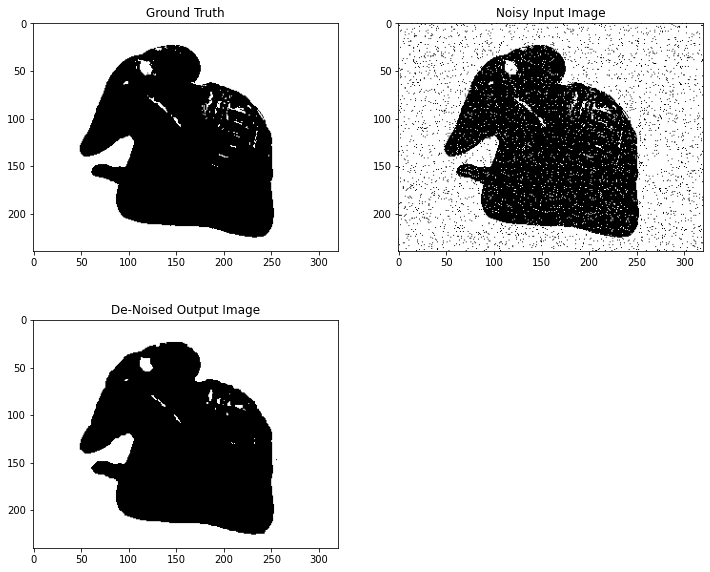

In [361]:
img1 = cv.imread("../../images/elefant.jpg", 0)
run(img1, 0.05, 2, sf=2, thres=127)

## Example 2

Initializing...
Creating Graph
Adding Edges
Finding MinCut


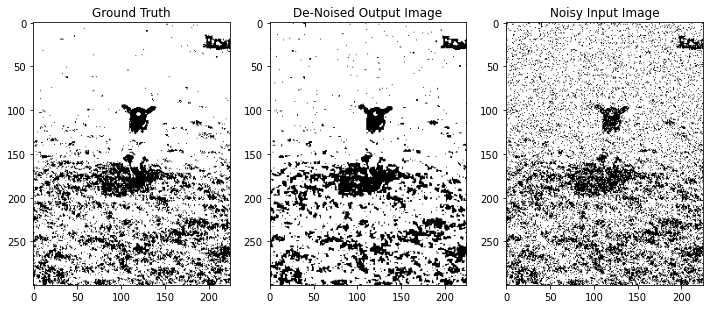

In [82]:
img1 = cv.imread("../../images/sheep.jpg", 0)
run(img1, 0.1, 1, sf=2, thres=120, g="h")

## Example 3

Initializing...
Creating Graph
Adding Edges
Finding MinCut


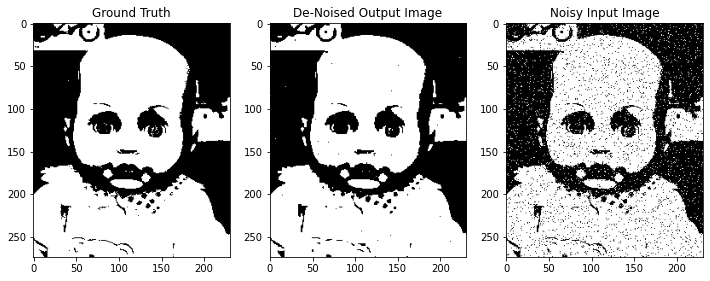

In [83]:
img1 = cv.imread("../../images/doll.jpg", 0)
run(img1, 0.05, 1.3, sf=2, g="h")

## Example 4

Initializing...
Creating Graph
Adding Edges
Finding MinCut


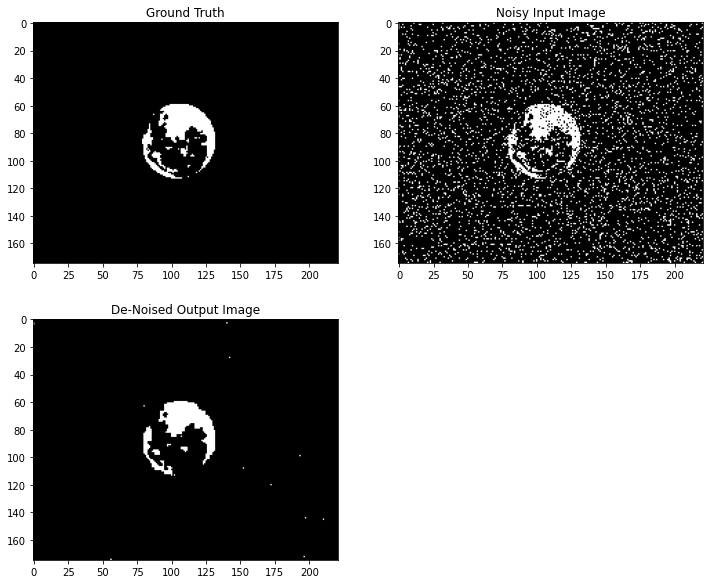

In [87]:
img1 = cv.imread("../../images/fullmoon.jpg", 0)
run(img1, 0.1, 1.5, sf=2, thres=120)

## Example 5

Initializing...
Creating Graph
Adding Edges
Finding MinCut


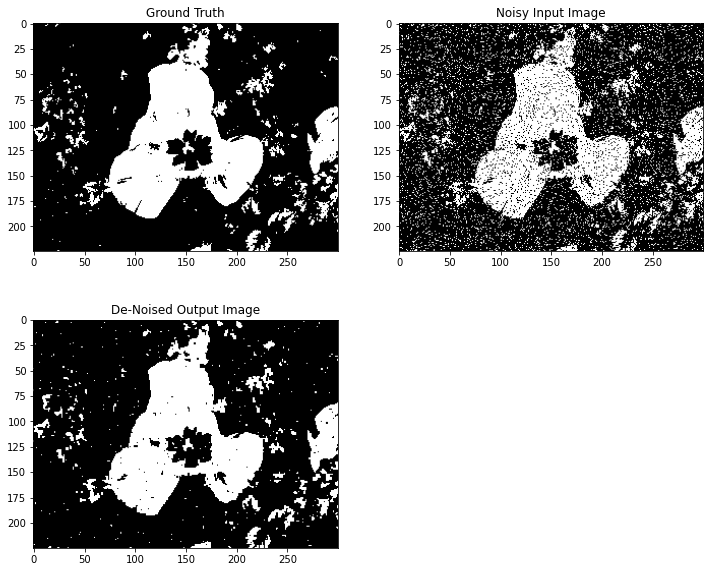

In [91]:
img1 = cv.imread("../../images/flower.jpg", 0)

run(img1, 0.1, 1, sf=2, thres=120)

## Comparison of Results with Varying amount of Noise

Initializing...
Creating Graph
Adding Edges
Finding MinCut
Initializing...
Creating Graph
Adding Edges
Finding MinCut
Initializing...
Creating Graph
Adding Edges
Finding MinCut


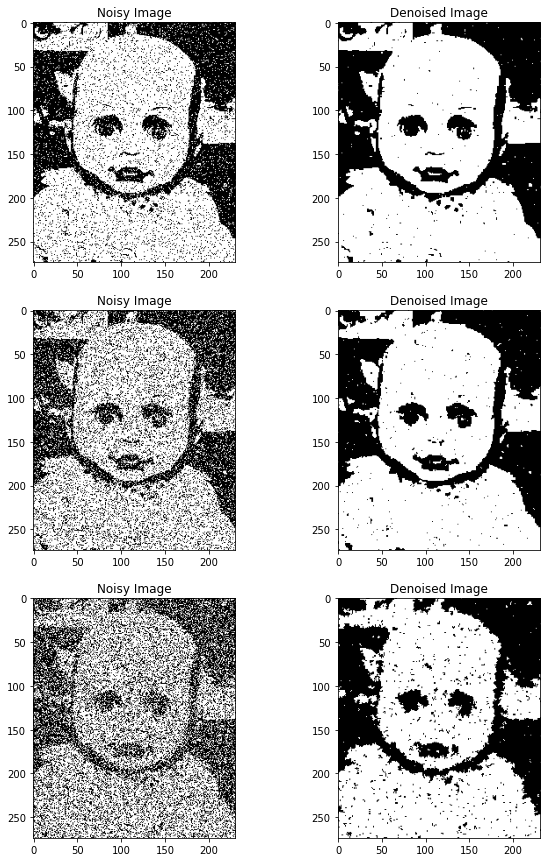

In [368]:
img = cv.imread("../../images/doll.jpg", 0)
n1,o1 = run(img, 0.09, 1, sf=2, thres=120, show=False)
n2,o2 = run(img, 0.2, 1, sf=2, thres=120, show=False)
n3,o3 = run(img, 0.3, 1, sf=2, thres=120, show=False)

plt.figure(figsize=(10,15))
plt.subplot(321)
plt.title("Noisy Image")
plt.imshow(n1, cmap="gray")
plt.subplot(323)
plt.title("Noisy Image")
plt.imshow(n2, cmap="gray")
plt.subplot(325)
plt.title("Noisy Image")
plt.imshow(n3, cmap="gray")
plt.subplot(322)
plt.title("Denoised Image")
plt.imshow(o1, cmap="gray")
plt.subplot(324)
plt.title("Denoised Image")
plt.imshow(o2, cmap="gray")
plt.subplot(326)
plt.title("Denoised Image")
plt.imshow(o3, cmap="gray")

---

# Denoising Colored Images using ICM

The unary potentials in this case represent the deviation from the current pixel value and the inter-pixel potentials represent the smoothness in intensity with respect to the neigboring pixels.

In [369]:
def get_min(img, ch, i,j, beta=50):
    
    h,w = img.shape[:2]
    c = img[i,j,ch]
    n1, n2, n3, n4 = 0,0,0,0
    
    n1 = img[i-1,j][ch]
    n2 = img[i,j-1][ch]
    n3 = img[(i+1)%h,j][ch]
    n4 = img[i,(j+1)%w][ch]

    vals = np.array([i for i in range(256)]).reshape(-1,1)

    costs = ((1/beta)*(vals - c)**2 + ((vals - n1)**2 + (vals - n2)**2 + (vals - n3)**2 + (vals - n4)**2)).ravel()
    return np.argmin(costs)

def denoise_img(img, n_iters=1, beta=1):
    
    img = img.copy()
    h,w = img.shape[:2]
    
    for i in range(h):
        for j in range(w):
            img[i,j,0] = get_min(img, 0, i, j, beta)
            img[i,j,1] = get_min(img, 1, i, j, beta)
            img[i,j,2] = get_min(img, 2, i, j, beta)
    
    if n_iters > 0:
        return denoise_img(img, n_iters-1)
    return img

def add_colored_noise(img, p=0.1):
    
    gaussian = np.abs(np.random.normal(0, p, img.shape))
    gaussian = np.random.normal(0, p, img.shape)
    print(gaussian.max())
    
    return (img + gaussian).astype('uint8')
    return (np.clip(img.astype('float32') + gaussian.astype('float32'), 0, 255)).astype('uint8')

## Example 1

In [370]:
img = cv.imread("../../images/fullmoon.jpg")[:,:,::-1]
noisy = add_colored_noise(img, 9)

42.32323477442015


In [355]:
out = denoise_img(noisy,1,0.2)

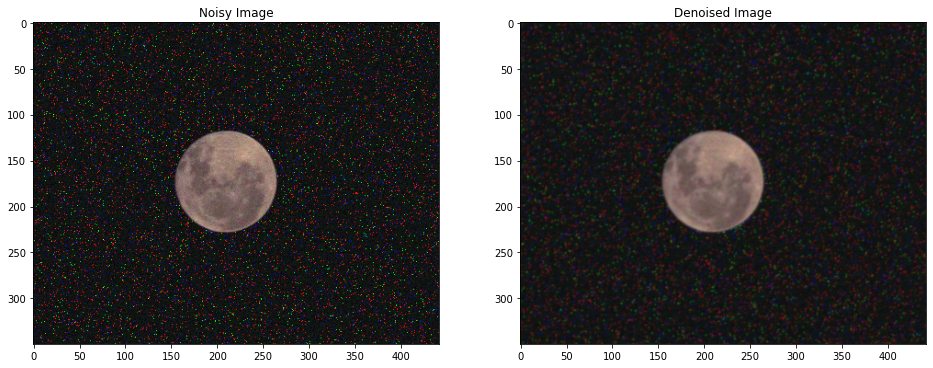

In [375]:
plt.figure(figsize=(16,10))
plt.subplot(121)
plt.title("Noisy Image")
plt.imshow(noisy)
plt.subplot(122)
plt.title("Denoised Image")
plt.imshow(out)

## Example 2

In [376]:
img = cv.imread("../../images/llama.jpg")[:,:,::-1]
noisy = add_colored_noise(img, 25)

114.08607858453222


In [377]:
out = denoise_img(noisy)

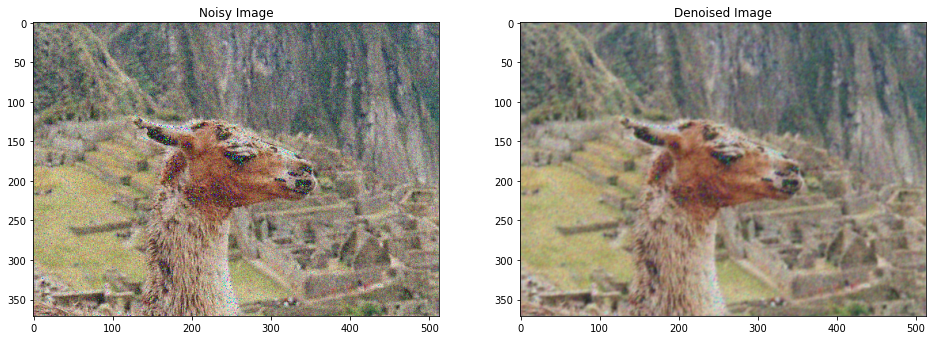

In [378]:
plt.figure(figsize=(16,10))
plt.subplot(121)
plt.title("Noisy Image")
plt.imshow(noisy)
plt.subplot(122)
plt.title("Denoised Image")
plt.imshow(out)

## Example 3

In [386]:
img = cv.imread("../../images/flower.jpg")[:,:,::-1]
noisy = add_colored_noise(img, 10)

46.20454189650994


In [387]:
out = denoise_img(noisy)

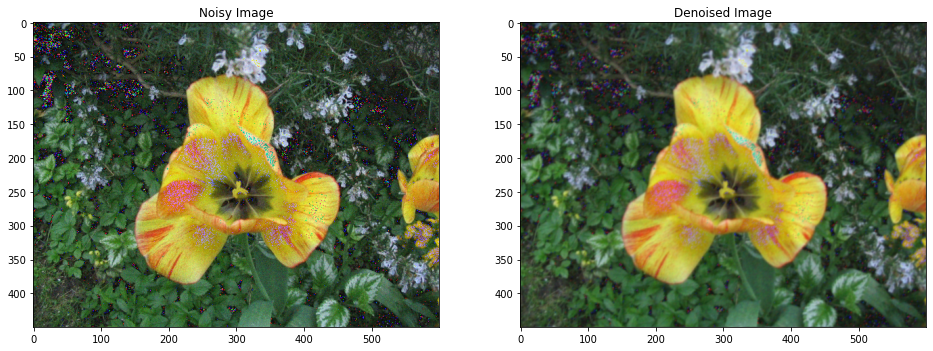

In [388]:
plt.figure(figsize=(16,10))
plt.subplot(121)
plt.title("Noisy Image")
plt.imshow(noisy)
plt.subplot(122)
plt.title("Denoised Image")
plt.imshow(out)

---